In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from fdasrsf import fPCA
import numpy as np
import skfda

import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)

warnings.filterwarnings('ignore', category=FutureWarning)

if not os.path.isdir('figures'):
    os.makedirs('figures')

In [2]:
def label_season(year):
    if year == 2020:
        return 'Season 10'
    if year == 2022:
        return 'Season 13'
    if year == 2023:
        return 'Season 15'
    return None


def add_days_after_planting(df, day_of_planting='2022-11-11'):
    day_of_planting = pd.to_datetime(day_of_planting)
    df['days_after_planting'] = (pd.to_datetime(df['date']) - day_of_planting).dt.days
    return df


def add_class_column(df):
    class_dict = {
        "Batavia": ["Iceberg", "La Brillante"],
        "Butterhead": ["Margarita", "Ninja"],
        "Crisphead": ["Emperor", "Salinas"],
        "Green leaf": ["Grand Rapids", "Salad Bowl"],
        "Red leaf": ["Lolla Rosa", "Merlot"],
        "Romaine": ["Green Towers", "Valmaine"]
    }

    def get_class(genotype):
        for class_name, genotypes in class_dict.items():
            if genotype in genotypes:
                return class_name
        return None

    df['class'] = df['genotype'].apply(get_class)
    return df

In [3]:
sns.set_context('talk', font_scale=1, rc={"lines.linewidth": 1.6}) #paper, notebook, talk, poster
#'poster', font_scale=0.5

# Get the 'Paired' color palette
palette = sns.color_palette("Paired")

# Define the RGB values for a lighter shade of brown
lighter_brown = (205/255 + 0.1, 133/255 + 0.1, 63/255 + 0.1)  # RGB values for lighter brown

# Replace yellow with light brown in the palette
palette[10] = lighter_brown

sns.set_palette(palette='colorblind') #palette)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [4]:
# Open data frame
df = pd.concat([pd.read_csv(csv) for csv in glob.glob('./blups/*/*.csv')])
df = df.rename(columns={'Unnamed: 0': 'genotype'})

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year from 'date'
df['year'] = df['date'].dt.year

In [5]:
# Apply the function to the 'year' column to create the 'season' column
df['season'] = df['year'].apply(label_season)

In [6]:
# Add days after planting
df_s10 = add_days_after_planting(df=df[df['season']== 'Season 10'], day_of_planting='2019-11-13')
df_s13 = add_days_after_planting(df=df[df['season']== 'Season 13'], day_of_planting='2021-12-02')
df_s15 = add_days_after_planting(df=df[df['season']== 'Season 15'], day_of_planting='2022-11-15')
df = pd.concat([df_s10, df_s13, df_s15])

/tmp/ipykernel_7072/3652984591.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_after_planting'] = (pd.to_datetime(df['date']) - day_of_planting).dt.days
/tmp/ipykernel_7072/3652984591.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_after_planting'] = (pd.to_datetime(df['date']) - day_of_planting).dt.days
/tmp/ipykernel_7072/3652984591.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [7]:
df = df[~df['genotype'].str.contains(':')]
df = df[~df['genotype'].isin(['rep', 'range', 'column'])]

In [8]:
# df = df[df['genotype']!='(Intercept)'].dropna(subset='solution')
df['genotype'] = df['genotype'].str.replace('genotype_', '')

In [9]:
df['genotype'] = df['genotype'].str.replace('_', ' ').str.replace('-', '')

In [10]:
line_list = ['Emperor',
'Grand Rapids',
'Green Towers',
'Iceberg',
'La Brillante',
'Lolla Rosa',
'Margarita',
'Merlot',
'Ninja',
'Salad Bowl',
'Salinas',
'Valmaine']

In [11]:
df = df[df['genotype'].isin(line_list)]

In [12]:
# Open data frame
df_her = pd.read_csv('./heritability/all_heritabilities.csv')

# Convert 'date' to datetime
df_her['date'] = pd.to_datetime(df_her['date'])

# Extract year from 'date'
df_her['year'] = df_her['date'].dt.year

# Apply the function to the 'year' column to create the 'season' column
df_her['season'] = df_her['year'].apply(label_season)

# Group by 'season' and 'trait', and calculate the mean of 'broad_sense_heritability'
grouped_df = df_her.groupby(['season', 'trait'])['broad_sense_heritability'].mean().reset_index()

# Filter the groups that have an average 'broad_sense_heritability' of more than 0.6
filtered_df = grouped_df[grouped_df['broad_sense_heritability'] > 0.8]
filtered_df = filtered_df[['season', 'trait']]

In [13]:
df = add_class_column(df=df)
df['genotype'] = df['genotype'].str.strip()
df['class'] = df['class'].str.strip()
df['trait'] = df['trait'].str.strip()

# Traditional

In [14]:
phenotype_list = [
    'hull_volume', 'height' #'axis_aligned_bounding_box', 'num_points' #, 'persistence_entropy_0' 'oriented_bounding_box', 
    # , 'length', 'width', 'num_points',  + ['persistence_entropy_0']
]

In [15]:
plot_df = df[df['trait'].isin(phenotype_list)]
# plot_df = add_class_column(df=plot_df)
# plot_df = plot_df.dropna(subset=['effect'])

In [16]:
plot_df['trait'] = plot_df['trait'].map({
    'axis_aligned_bounding_box': 'Axis-Aligned Bounding Volume (cm³)',
    'height': 'Height (cm)',
    'hull_volume': 'Hull Volume (cm³)',
    'num_points': 'Number of Points'
})
plot_df = plot_df.sort_values(['class', 'genotype'])

/tmp/ipykernel_7072/407281485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['trait'] = plot_df['trait'].map({


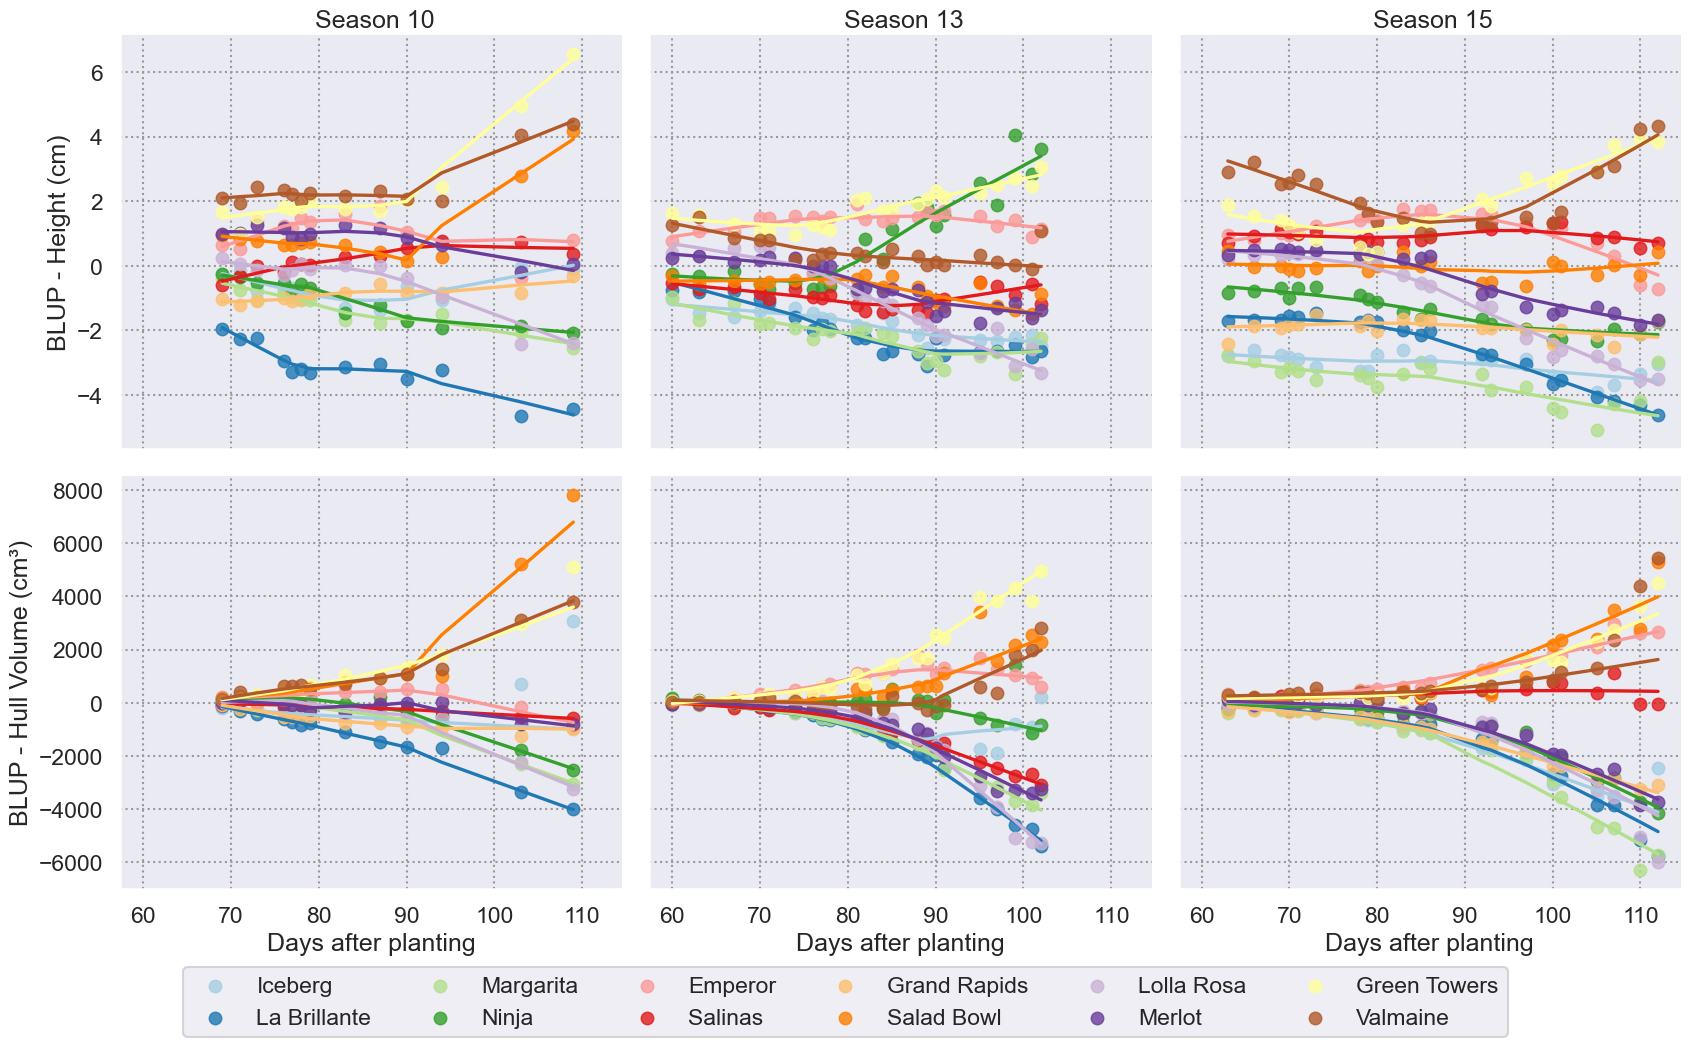

In [17]:
# g = sns.lmplot(
#     x='days_after_planting',
#     y='effect',
#     hue='genotype',
#     col='season',
#     col_order=['Season 10', 'Season 13', 'Season 15'],
#     row='trait',
#     data=plot_df.sort_values('class'),
#     lowess=True,
#     # scatter=False,
#     # kind='scatter',
#     facet_kws={'sharex': True, 'sharey': False},
#     palette='Paired'
# )
# g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
# g.set_axis_labels("Days after planting", "Genotype BLUPs")
# # g.set_titles("{col_name}")
# # g.fig.suptitle(trait)

# ####
# # Set y-axis title for each subplot
# for (row_name, col_name), ax in g.axes_dict.items():
    
#     ax.set_ylabel(row_name)


# # Only set column names at the top most and remove "Principal Component 1" from the column name
# cnt = 0
# for ax in g.axes.flat:
#     label = ax.get_title()
#     # label = label.split('|')[1]

#     if cnt <= 2:
#         ax.set_title(label.split('|')[1])
#     else:
#         ax.set_title('')
    
#     cnt += 1
# ####

# plt.savefig('figures/blup_lowess_traditional.png', dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
# plt.show()
g = sns.FacetGrid(plot_df, row='trait', col='season', hue='genotype', 
                  col_order=['Season 10', 'Season 13', 'Season 15'], sharex=True, sharey='row', 
                  palette='Paired', height=5) #, aspect=1.5)
g.map(sns.regplot, 'days_after_planting', 'solution', lowess=True)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_axis_labels("Days after planting", "Genotype BLUPs")

# Set y-axis title for each subplot
for (row_name, col_name), ax in g.axes_dict.items():
    ax.set_ylabel(f'BLUP - {row_name}')

# Only set column names at the top most and remove "Principal Component 1" from the column name
cnt = 0
for ax in g.axes.flat:
    label = ax.get_title()
    if cnt <= 2:
        ax.set_title(label.split('|')[1])
    else:
        ax.set_title('')
    cnt += 1

# Move the legend to bottom center
g = g.add_legend()
g = sns.move_legend(g, "center", bbox_to_anchor=(0.5, -0.02), ncol=6, frameon=True, title=None) #, title='Genotype')

# Adjust the padding around the edge of the figure
plt.tight_layout()

plt.savefig('figures/blup_lowess_traditional.png', dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()


# Topological

In [18]:
# phenotype_list = df[df['trait'].str.contains('_0')]['trait'].unique().tolist()

In [19]:
phenotype_list = [
    # 'amplitude_betti_0',
    # 'amplitude_bottleneck_0',
    'amplitude_heat_0',
    # 'amplitude_landscape_0',
    # 'amplitude_persistence_image_0',
    # 'amplitude_silhouette_0',
    # 'amplitude_wasserstein_0',
    'number_points_0',
    # 'persistence_entropy_0'
]

In [20]:
plot_df = df[df['trait'].isin(phenotype_list)]
# plot_df = add_class_column(df=plot_df)
# plot_df = plot_df.dropna(subset=['effect'])

In [21]:
plot_df['trait'] = plot_df['trait'].str.replace('_0', '').str.replace('_', ' ').str.title()
plot_df = plot_df.sort_values(['class', 'genotype'])

/tmp/ipykernel_7072/694437751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['trait'] = plot_df['trait'].str.replace('_0', '').str.replace('_', ' ').str.title()


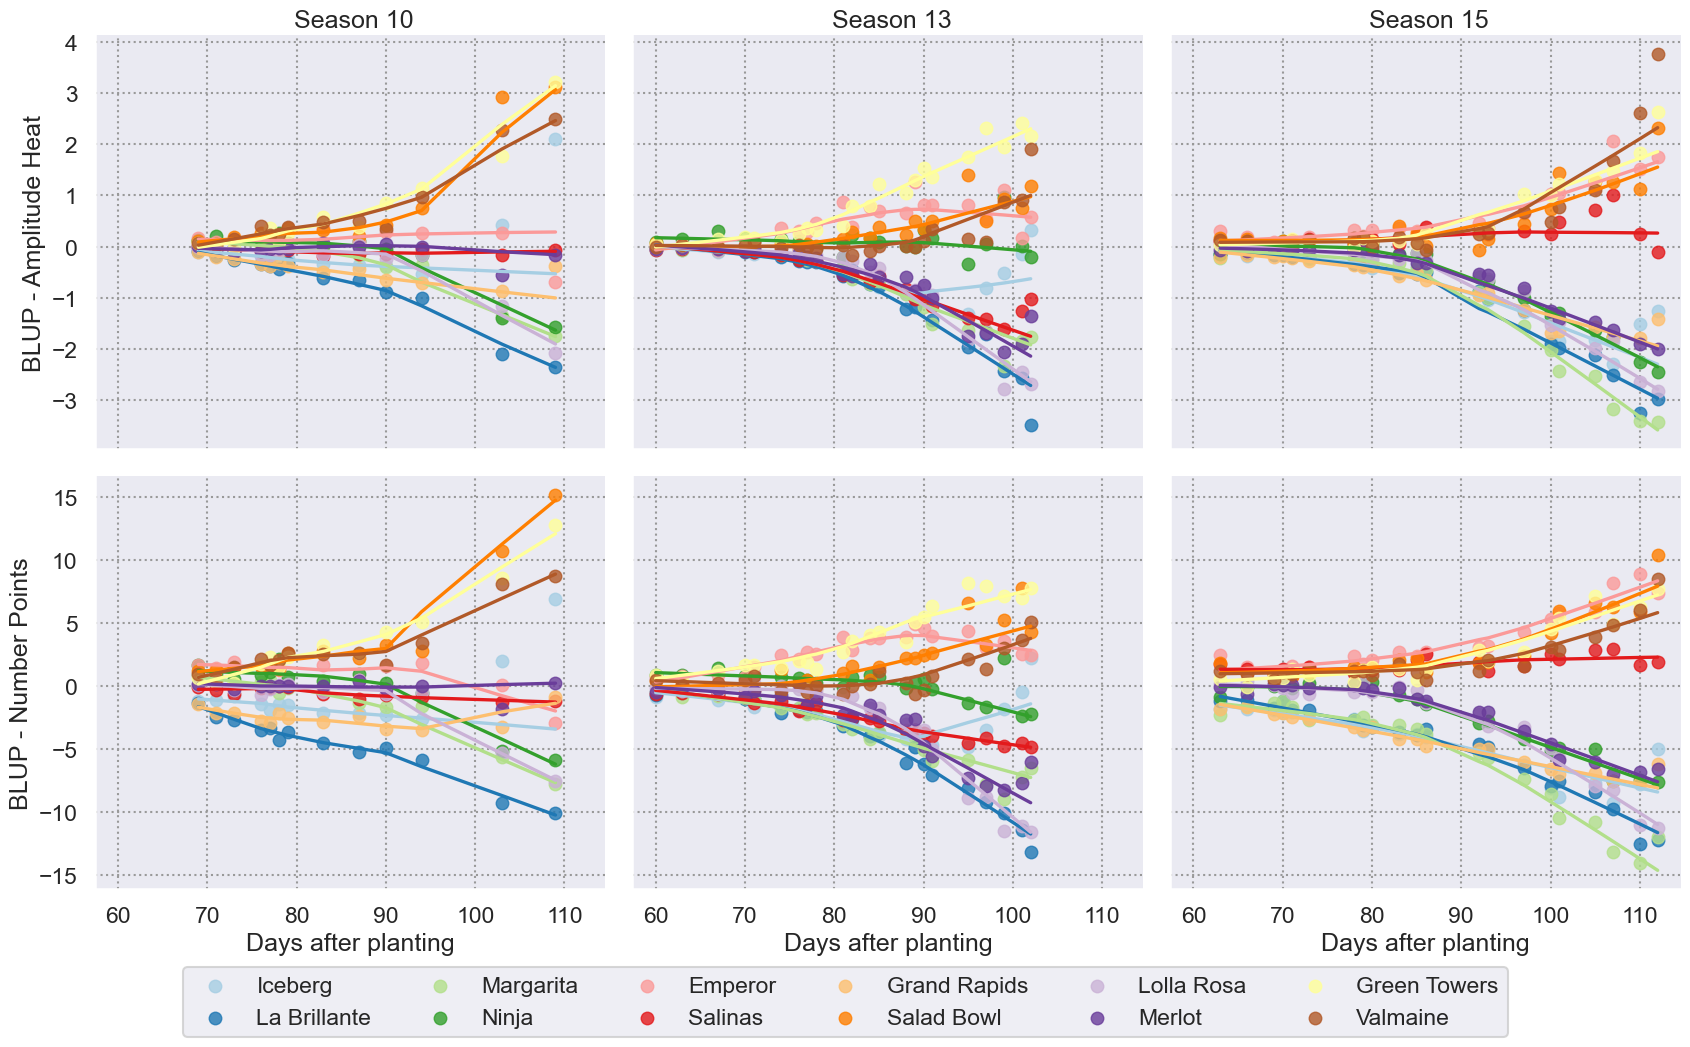

In [22]:
# g = sns.lmplot(
#     x='days_after_planting',
#     y='effect',
#     hue='genotype',
#     col='season',
#     col_order=['Season 10', 'Season 13', 'Season 15'],
#     row='trait',
#     data=plot_df.sort_values('class'),
#     lowess=True,
#     # scatter=False,
#     # kind='scatter',
#     facet_kws={'sharex': True, 'sharey': False},
#     palette='Paired'
# )
# g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
# g.set_axis_labels("Days after planting", "Genotype BLUPs")
# # g.set_titles("{col_name}")
# # g.fig.suptitle(trait)

# ####
# # Set y-axis title for each subplot
# for (row_name, col_name), ax in g.axes_dict.items():
    
#     ax.set_ylabel(row_name)


# # Only set column names at the top most and remove "Principal Component 1" from the column name
# cnt = 0
# for ax in g.axes.flat:
#     label = ax.get_title()
#     # label = label.split('|')[1]

#     if cnt <= 2:
#         ax.set_title(label.split('|')[1])
#     else:
#         ax.set_title('')
    
#     cnt += 1
# ####

# plt.savefig('figures/blup_lowess_topological.png', dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
# plt.show()
g = sns.FacetGrid(plot_df, row='trait', col='season', hue='genotype', 
                  col_order=['Season 10', 'Season 13', 'Season 15'], sharex=True, sharey='row', 
                  palette='Paired', height=5) #, aspect=1.5)
g.map(sns.regplot, 'days_after_planting', 'solution', lowess=True)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_axis_labels("Days after planting", "Genotype BLUPs")

# Set y-axis title for each subplot
for (row_name, col_name), ax in g.axes_dict.items():
    ax.set_ylabel(f'BLUP - {row_name}')

# Only set column names at the top most and remove "Principal Component 1" from the column name
cnt = 0
for ax in g.axes.flat:
    label = ax.get_title()
    if cnt <= 2:
        ax.set_title(label.split('|')[1])
    else:
        ax.set_title('')
    cnt += 1

# Move the legend to bottom center
g = g.add_legend()
g = sns.move_legend(g, "center", bbox_to_anchor=(0.5, -0.02), ncol=6, frameon=True, title=None) #, title='Genotype')

# Adjust the padding around the edge of the figure
plt.tight_layout()

plt.savefig('figures/blup_lowess_topological.png', dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()